In [5]:
# # Task 1: Preprocess and Explore the Data

# ## Executive Summary
# **Objective:** Prepare and analyze historical financial data for TSLA, BND, and SPY to inform forecasting models.

# **Scope:**
# 1.  **Data Extraction:** Jan 1, 2015 – Jan 15, 2026 (YFinance)
# 2.  **Cleaning:** Handling missing values and ensuring correct data types.
# 3.  **EDA:** Visualizing trends, volatility, and rolling statistics.
# 4.  **Analysis:** Testing for stationarity (ADF) and calculating risk metrics (VaR, Sharpe).
# 5.  **Scaling:** Normalizing data for potential deep learning models.

In [1]:
# 1. Setup and Imports
import sys
import os

# Add the 'src' directory to the system path to import modules
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import custom modules from src/
from src.data_loader import fetch_financial_data, clean_data
from src.analysis import calculate_daily_returns, check_stationarity, calculate_risk_metrics, detect_outliers

# Configure Plotting Style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 12

In [3]:
# ## 2. Data Extraction & Cleaning
# We fetch data for **Tesla (TSLA)** (High Growth), **Vanguard Bond ETF (BND)** (Safety), and **S&P 500 (SPY)** (Benchmark).

In [5]:
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-01-01'
end_date = '2026-01-15'

# Fetch Data
raw_data = fetch_financial_data(tickers, start_date, end_date)
# Clean Data
data = clean_data(raw_data)

# --- ROBUST EXTRACTION LOGIC ---
# Create an empty DataFrame
close_df = pd.DataFrame()

# Loop through each ticker and safely extract the 'Close' or 'Adj Close'
for ticker in tickers:
    try:
        # Try to get Adj Close first (preferred)
        if (ticker, 'Adj Close') in data.columns:
            close_df[ticker] = data[(ticker, 'Adj Close')]
        elif (ticker, 'Close') in data.columns:
            close_df[ticker] = data[(ticker, 'Close')]
        else:
            # Fallback for flat structure or different naming
            close_df[ticker] = data['Adj Close'][ticker]
    except KeyError:
        print(f"Warning: Could not find data for {ticker}")

# Display first 5 rows to verify structure
print("Data Shape:", close_df.shape)
close_df.head()

2026-02-14 22:53:08,247 - Fetching ['TSLA', 'BND', 'SPY'] data...
[*********************100%***********************]  3 of 3 completed
2026-02-14 22:53:08,474 - Data fetched successfully.


Data Shape: (2775, 3)


,TSLA,BND,SPY
Date,,,
2015-01-02,14.620667,60.186657,170.589600
2015-01-05,14.006000,60.361431,167.508804
2015-01-06,14.085333,60.536186,165.931076
2015-01-07,14.063333,60.572628,167.998764
2015-01-08,14.041333,60.477970,170.979904


In [ ]:
# ## 3. Exploratory Data Analysis (EDA)

# ### Visualization A: Closing Price Over Time
# Comparing the growth trajectory of the three assets.

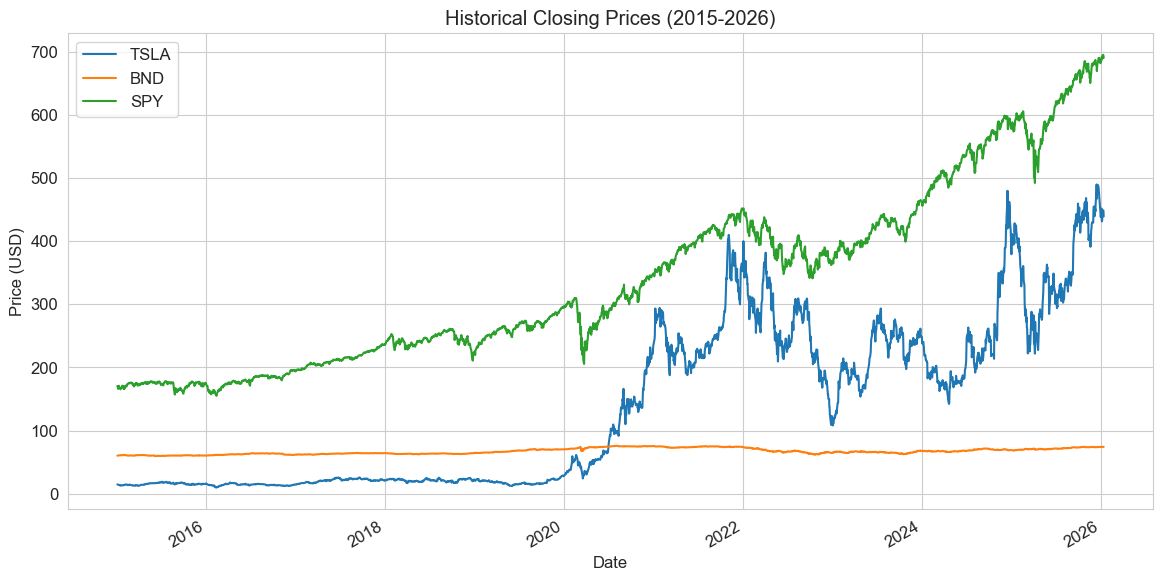

In [6]:
close_df.plot(linewidth=1.5)
plt.title('Historical Closing Prices (2015-2026)')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.show()

In [ ]:
# ### Visualization B: Daily Returns (Volatility Analysis)
# We calculate daily percentage changes to observe volatility clusters.

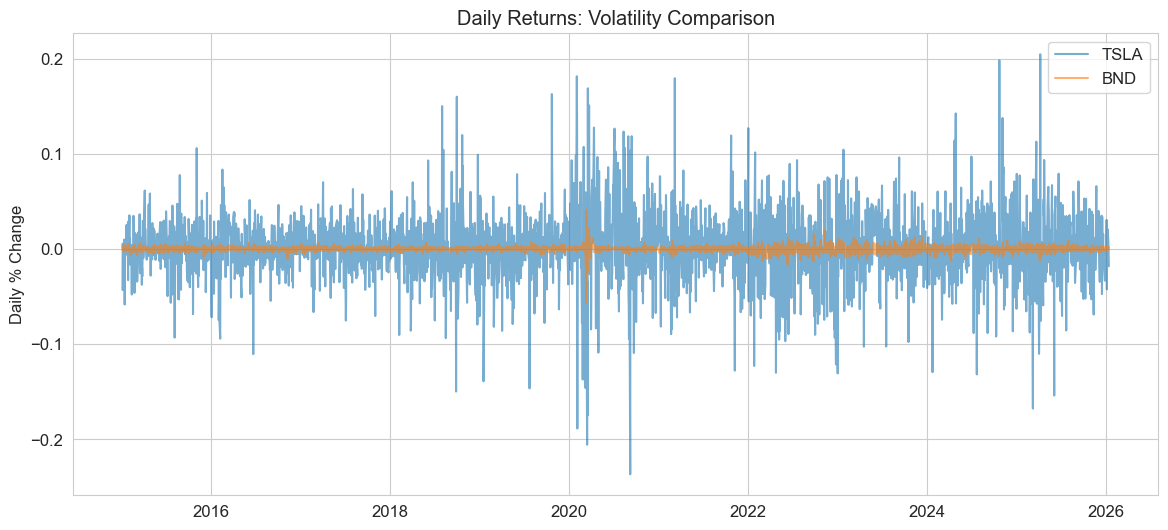

In [7]:
returns_df = calculate_daily_returns(close_df)

plt.figure(figsize=(14, 6))
plt.plot(returns_df.index, returns_df['TSLA'], label='TSLA', alpha=0.6)
plt.plot(returns_df.index, returns_df['BND'], label='BND', alpha=0.6)
plt.title('Daily Returns: Volatility Comparison')
plt.ylabel('Daily % Change')
plt.legend()
plt.show()

In [ ]:
# ### Visualization C: Rolling Mean & Standard Deviation
# **Rubric Requirement:** Analyze short-term trends and fluctuations.

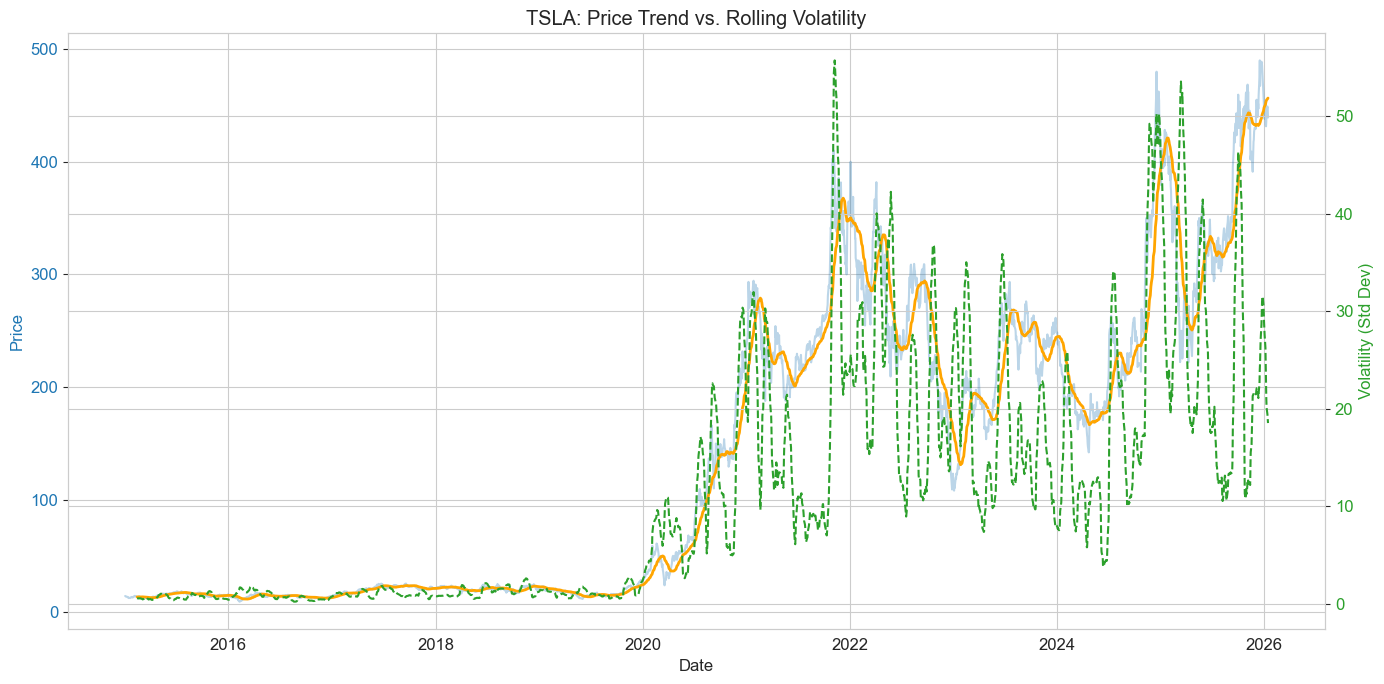

In [8]:
# Rolling window of 30 days (approx 1 trading month)
rolling_mean = close_df['TSLA'].rolling(window=30).mean()
rolling_std = close_df['TSLA'].rolling(window=30).std()

fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color=color)
ax1.plot(close_df.index, close_df['TSLA'], label='TSLA Price', color=color, alpha=0.3)
ax1.plot(rolling_mean.index, rolling_mean, label='30-Day Rolling Mean', color='orange', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Volatility (Std Dev)', color=color)
ax2.plot(rolling_std.index, rolling_std, label='30-Day Rolling Std Dev', color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('TSLA: Price Trend vs. Rolling Volatility')
fig.tight_layout()
plt.show()

In [ ]:
# ## 4. Outlier Detection
# Identifying days with extreme returns (greater than 3 standard deviations).

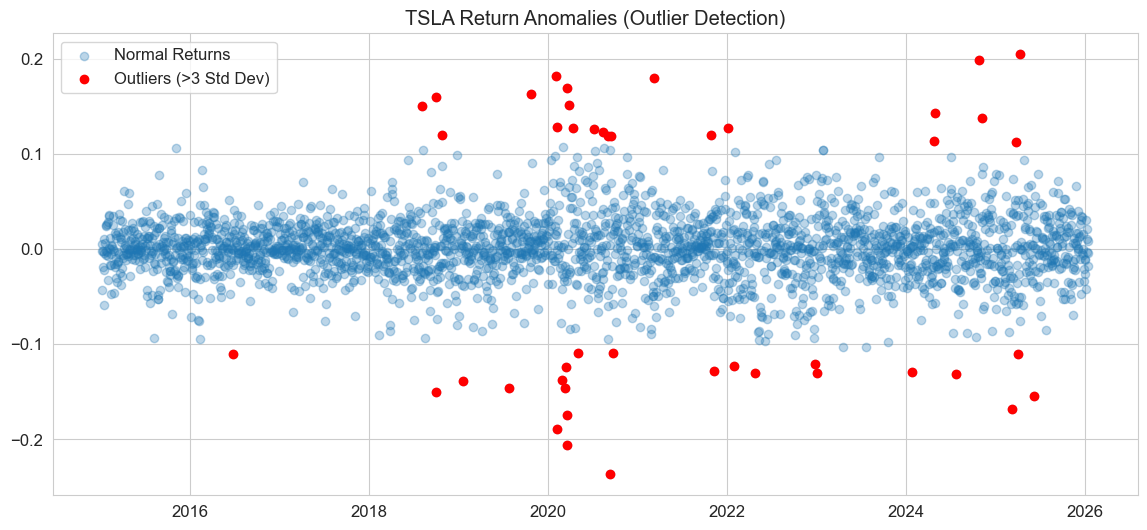

Detected 45 outlier days for TSLA.


In [9]:
tsla_outliers = detect_outliers(returns_df['TSLA'])

plt.figure(figsize=(14, 6))
plt.scatter(returns_df.index, returns_df['TSLA'], alpha=0.3, label='Normal Returns')
plt.scatter(tsla_outliers.index, tsla_outliers, color='red', label='Outliers (>3 Std Dev)')
plt.title('TSLA Return Anomalies (Outlier Detection)')
plt.legend()
plt.show()

print(f"Detected {len(tsla_outliers)} outlier days for TSLA.")

In [ ]:
# ## 5. Stationarity Test (ADF Test)
# We use the Augmented Dickey-Fuller test to check if the data is stationary (a requirement for ARIMA models).

# *   **H0:** The series is non-stationary.
# *   **H1:** The series is stationary.
# *   **Rule:** If p-value < 0.05, we reject H0 (Stationary).

In [10]:
print("--- Stationarity: TSLA Closing Prices ---")
print(check_stationarity(close_df['TSLA']))

print("\n--- Stationarity: TSLA Daily Returns ---")
print(check_stationarity(returns_df['TSLA']))

--- Stationarity: TSLA Closing Prices ---
Test Statistic         -0.780157
p-value                 0.824881
# Lags Used                 28.0
# Observations Used       2746.0
Critical Value (1%)    -3.432734
Critical Value (5%)    -2.862593
Critical Value (10%)   -2.567331
Is Stationary (5%)         False
dtype: object

--- Stationarity: TSLA Daily Returns ---
Test Statistic         -12.281441
p-value                       0.0
# Lags Used                  18.0
# Observations Used        2755.0
Critical Value (1%)     -3.432726
Critical Value (5%)      -2.86259
Critical Value (10%)    -2.567329
Is Stationary (5%)           True
dtype: object


In [ ]:
# **Interpretation:** 
# *   **Prices:** Usually have a high p-value (Non-stationary). This confirms we must use differencing ('d' parameter) in ARIMA.
# *   **Returns:** Usually have a low p-value (Stationary). This confirms returns are safe to model directly.

In [ ]:
# ## 6. Risk Metrics Analysis
# Calculating Value at Risk (VaR) and Sharpe Ratio to quantify risk/reward.

In [11]:
risk_metrics = calculate_risk_metrics(returns_df)
print(risk_metrics)

        VaR_95  Sharpe_Ratio
TSLA -0.053959      0.537322
BND  -0.004808      0.354012
SPY  -0.016860      0.713216


In [ ]:
# ## 7. Data Normalization/Scaling
# For Machine Learning models (like LSTM in Task 2), data often needs to be scaled between 0 and 1.

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# Reshape for scaler (needs 2D array)
tsla_values = close_df['TSLA'].values.reshape(-1, 1)
scaled_data = scaler.fit_transform(tsla_values)

print(f"Scaled Data Sample (First 5):\n {scaled_data[:5]}")

Scaled Data Sample (First 5):
 [[0.01049895]
 [0.0092192 ]
 [0.00938437]
 [0.00933857]
 [0.00929276]]


In [ ]:
# ## 8. Export Processed Data
# Saving the cleaned data for use in the modeling notebook.

In [13]:
# Ensure directory exists
os.makedirs('../data/processed', exist_ok=True)

close_df.to_csv('../data/processed/cleaned_close_prices.csv')
returns_df.to_csv('../data/processed/daily_returns.csv')

print("Data successfully saved to data/processed/")

Data successfully saved to data/processed/
